In [5]:
import random, csv, sys, itertools
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
import operator
import datetime
import sys

# How does the pattern between killer/victim look between various incidents
# over the years. Is it mostly family/relation or do we see more reported gang
# violence for instance?

df = pd.read_csv('data/clean_data_v1.csv', parse_dates=['date'])


In [14]:
df.iloc[0]

incident_id                                                               461105
date                                                         2013-01-01 00:00:00
state                                                               Pennsylvania
city_or_county                                                        Mckeesport
address                                1506 Versailles Avenue and Coursin Street
n_killed                                                                       0
n_injured                                                                      4
incident_url                   http://www.gunviolencearchive.org/incident/461105
source_url                     http://www.post-gazette.com/local/south/2013/0...
incident_url_fields_missing                                                False
congressional_district                                                        14
gun_stolen                                                            0::Unknown
gun_type                    

In [6]:
def csv_dict_to_py_dict(csv_string):
    if '::' in csv_string:
        py_dict = dict((key, value) for key, value in (item.split('::') for item in csv_string.split('||')))
    elif ':' in csv_string:
        py_dict = dict((key, value) for key, value in (item.split(':') for item in csv_string.split('|')))
    return py_dict


In [19]:
df["date"]=pd.to_datetime(df["date"],format="%Y-%m-%d")
df["Year"]=df["date"].apply(lambda time:time.year)
df["Month"]=df["date"].apply(lambda time:time.month)
df["Day"]=df["date"].apply(lambda time:time.day)
df["Day_of_Week"]=df["date"].apply(lambda time:time.dayofweek)
dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}#We're Using this Dictionary to Map our column
df["Day_of_Week"]=df["Day_of_Week"].map(dmap)

df.head(2)

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district,Year,Month,Day,Day_of_Week
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::Unknown,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,0::Unknown,0::Unknown,2013,1,1,Tue
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::Unknown,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62,35,2013,1,1,Tue


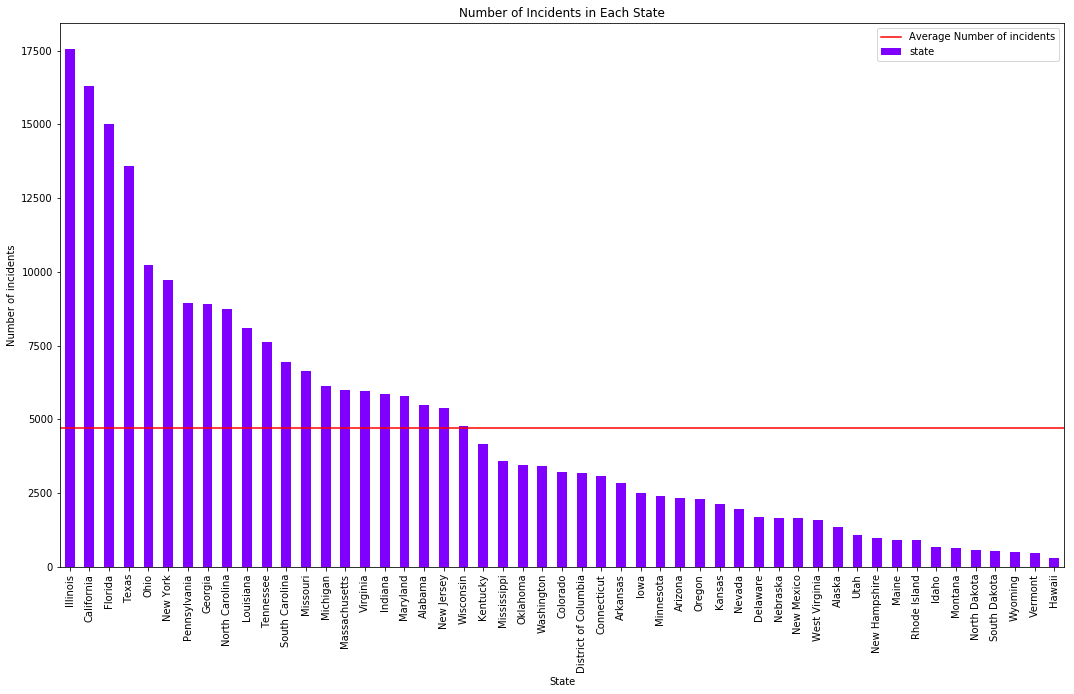

In [14]:
plot = df.state.value_counts().plot(kind='bar', \
                                     title="Number of Incidents in Each State", \
                                     figsize=(18,10), \
                                     colormap='rainbow')
plot.set_xlabel('State')
plot.set_ylabel('Number of incidents')
mean_line = plot.axhline(df.state.value_counts().mean(), color='r',\
                         label='Average Number of incidents')
plt.legend()
plt.show()